# TP53 trans effects on known interacting proteins (proteomic analysis)
## This was our first analysis, used to detect significant changes in proteins known to interact with TP53

### Standard imports, including CPTAC package

In [26]:
import pandas as pd
import numpy as np
import re
import scipy.stats
import statsmodels.stats.multitest
import matplotlib.pyplot as plt
import seaborn as sns
import CPTAC.Endometrial as CPTAC

### Set up initial dataframes and variables

In [27]:
gene='TP53'
somatic = CPTAC.get_somatic()
proteomics = CPTAC.get_proteomics()
phos = CPTAC.get_phosphoproteomics()
transcriptomics = CPTAC.get_transcriptomics()

# A list of mutations present in the hotspot according to our Hotspot3D output
hotspot_mutations = ['p.P250L', 'p.R248W', 'p.S241C', 'p.241del','p.K164E', 'p.R249S', 'p.R273H', 'p.R282W',
                    'p.S127Y', 'p.G244D', 'p.A159P']
mutated_hotspot = somatic.loc[(somatic['Location'].isin(hotspot_mutations)) & (somatic['Gene'] == gene)]

# Get a list of patient identifiers for those who have mutations in the hotspot
hotspot_patients_both_keys = mutated_hotspot[['Clinical_Patient_Key', 'Patient_Id']]
hotspot_patients = hotspot_patients_both_keys['Clinical_Patient_Key']
hotspot_patients

586      S001
1318     S006
1404     S008
4019     S015
4089     S016
4736     S020
44973    S071
45005    S072
46785    S082
49867    S096
49948    S097
Name: Clinical_Patient_Key, dtype: object

### Find number of patients with TP53 mutations in/outside of hotspot

In [28]:
print("Mutations inside hotspot: " + str(len(hotspot_patients)))
p53_mutated = somatic.loc[somatic['Gene'] == 'TP53']

# num_mutated naturally includes a value that is 'NA' so we subtract 1
# Some people have more than one mutation so we need to grab the unique values
num_mutated = len(set(p53_mutated['Clinical_Patient_Key'])) - 1
print("Total number of patients with mutations: " + str(num_mutated))

Mutations inside hotspot: 11
Total number of patients with mutations: 23


### List of proteins that interact with TP53 (according to Uniprot and String)

In [29]:
interProtList = ['AIMP2', 'ARIH2', 'ARRB1', 'ASH2L', 'ATG7', 'AXIN1', 'BANP', 'BCL2', 'BCL2L1', 'BCR', 'BHLHE40', 'BRCA2',
           'BRD7', 'BTBD2', 'BTRC', 'CABLES1', 'CARM1', 'CCDC106', 'CDKN1A', 'CEBPB', 'CHD8', 'CREBBP', 'CSE1L', 'CSNK2A1', 'CUL7',
           'CUL9', 'CXXC1', 'DAXX', 'DDX17', 'DDX5', 'DROSHA', 'DUSP26', 'DVL2', 'E6', 'EP300', 'ETS2', 'FBXO11',
           'FOXO3', 'GSK3B', 'GTF2H1', 'HDAC1', 'HIPK1', 'HIPK2', 'HMGB1', 'HNRNPK', 'HRMT1L2', 'HSP82', 'HSPA1L', 'HSPA9', 'HSPB1',
           'HTT', 'HUWE1', 'IFI16', 'IFI205B', 'ING4', 'IKBKB', 'IP6K2', 'JMJD6', 'KAT5', 'KAT8', 'KDM1A', 'KMT2E', 'LAMA4',
           'MAGEA2B', 'MAGEC2', 'MAP1B', 'MAPK11', 'MAPKAPK5', 'MDM2', 'MDM4', 'MKRN1', 'MPDZ', 'MT1A', 'NCL', 'NCOR2',
           'NFYA', 'NFYB', 'NOC2L', 'NOL3', 'NPM1', 'NR0B2', 'NR4A1', 'NRDC', 'NSP1', 'NUAK1', 'NUMB', 'OTUB1', 
           'PARD3', 'PARP1', 'PBK', 'PHB', 'PIAS1', 'PIAS2', 'PIAS4', 'PIN1', 'PLK1', 'PML', 'PPIF', 'PPP1CC',
           'PPP1R13L', 'PPP2R1A', 'PPP2R5C', 'PRKCD', 'PSME3', 'PTK2', 'RAD51', 'RBPJ', 'RCHY1', 'RFWD3', 'RING1',
           'RPS3', 'RYBP', 'S100A1', 'S100A2', 'S100A4', 'S100B', 'SAFB', 'SETD7', 'SFN', 'SIN3A', 'SIRT1', 'SMAD2',
           'SMYD2', 'SNAT1', 'SOX4', 'SP1', 'SREBF2', 'SRPK1', 'SUMO1', 'SYVN1', 'TAF1', 'TBP', 'TCF4', 'TOE1', 'TP53BP1',
           'TP53BP2', 'TP53INP1', 'TP63', 'TPT1', 'TRIM24', 'TWIST1', 'UBC', 'UBE3A', 'UHRF2', 'USP42', 'USP7', 'VDR', 'VRK1',
           'WRN', 'WWOX', 'XPO1', 'XRCC6', 'YWHAG', 'YWHAZ', 'ZNF420', 'ATM', 'BAX', 'BCL2L11', 'CCNA1', 'CCNA2', 'CCNB1', 
           'CCNB2', 'CCND1', 'CCND3', 'CCNE1', 'CCNE2', 'CDC25A', 'CDC6', 'CDK2', 'CDKN1B', 'CDKN2A', 'CHEK1', 
           'CHEK2', 'CITED2', 'CKS1B', 'MCM5', 'MRE11A', 'PCNA', 'RB1', 'ARMC10', 'BANP', 'CDKN2AIP', 'NUAK1', 'STK11',
           'LKB1', 'UHRF2', 'E4F1', 'MAML1', 'MKRN1', 'PML', 'FBXO42', 'ATM', 'PP2A', 'PPP2R5C', 'PPP2R2A', 'AURKA', 'DAXX',
           'BRD7', 'TRIM24', 'L3MBTL1', 'GRK5', 'CAK', 'CDK7', 'MAT1', 'CDK5', 'AURKB', 'SETD2', 'UHRF2', 'NOC2L', 'PTK2',
           'FAK1', 'PTK2B', 'PYK2', 'PRKCG', 'PPIF', 'SNAI1', 'KAT6A', 'ANKRD2', 'RFFL', 'RNF34', 'MTA1', 'COP1', 'CCAR2',
           'MORC3', 'POU4F2', 'NOP53', 'AFG1L', 'UBD', 'TAF6', 'FATS', 'C10ORF90']

### All mutations vs. cancer wildtype

In [30]:
significant_all_mut_wt = {}
# Bonferroni correction of p-value significance cutoff to account for multiple hypothesis testing
pcutoff = 0.05 / len(interProtList)

for protein in interProtList:
    if (protein != 'idx') and (protein != gene) and protein in proteomics.columns:
        # Create dataframe with mutation status of TP53 with proteomics of the given protein
        p53_mutations_protein = CPTAC.compare_mutations(proteomics, protein, gene)
        # Create a column showing the location of TP53 mutation
        p53_mutations_protein['Within_Hotspot'] = False
        p53_mutations_protein.loc[hotspot_patients, 'Within_Hotspot'] = True
        p53_mutations_protein.loc[p53_mutations_protein['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'
        p53_mutations_protein = p53_mutations_protein.loc[p53_mutations_protein['Patient_Type'] == 'Tumor'].dropna(axis=0)
        # Perform the ttest
        mutated_tp53 = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] != 'Wildtype']
        wt_tp53 = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == 'Wildtype']
        if len(mutated_tp53) < 2: continue
        ttest = scipy.stats.ttest_ind(mutated_tp53[protein], wt_tp53[protein])
        if ttest[1] <= pcutoff:
            significant_all_mut_wt[protein] = ttest[1]
            
significant_all_mut_wt

{'CABLES1': 1.1764566319746612e-05,
 'CHD8': 8.522109920366445e-06,
 'CSE1L': 1.8890339652969574e-08,
 'CSNK2A1': 0.00019247686362858961,
 'DAXX': 3.3740745498878604e-05,
 'NCL': 1.3409000807290296e-06,
 'NOC2L': 5.307164497194313e-06,
 'PLK1': 7.295527266933368e-06,
 'VRK1': 7.883453284246696e-07,
 'XPO1': 1.6459193780890785e-08,
 'CCNA2': 3.5702295719252706e-05,
 'CCNB1': 1.8079893257179908e-05,
 'CDKN2A': 0.00011961545983524085,
 'MCM5': 3.3439849346989614e-05,
 'STK11': 2.953191637473529e-05,
 'AURKA': 1.6061961577564404e-05,
 'AURKB': 0.0001507316136540888}

### Mutations outside of the hotspot vs. cancer wildtype

In [31]:
significant_nonhtspt_wt = {}
pcutoff = 0.05 / len(interProtList)

for protein in interProtList:
    if (protein != 'idx') and (protein != gene) and protein in proteomics.columns:
        p53_mutations_protein = CPTAC.compare_mutations(proteomics, protein, gene)
        p53_mutations_protein['Within_Hotspot'] = False
        p53_mutations_protein.loc[hotspot_patients, 'Within_Hotspot'] = True
        p53_mutations_protein.loc[p53_mutations_protein['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'
        p53_mutations_protein = p53_mutations_protein.loc[p53_mutations_protein['Patient_Type'] == 'Tumor'].dropna(axis=0)
        mutated = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == False]
        wt = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == 'Wildtype']
        if len(mutated) < 2: continue
        ttest = scipy.stats.ttest_ind(mutated[protein], wt[protein])
        if ttest[1] <= pcutoff:
            significant_nonhtspt_wt[protein] = ttest[1]
            
significant_nonhtspt_wt

{'CABLES1': 7.106237044120236e-05,
 'CHD8': 3.0756599349456866e-05,
 'CSE1L': 1.853238564488548e-06,
 'NCL': 9.564339899364772e-05,
 'XPO1': 5.556336118188905e-05}

### Hotspot mutation vs. cancer wildtype

In [32]:
significant_htspt_wt = {}
# Bonferroni correction of p-value significance cutoff to account for multiple hypothesis testing
pcutoff = 0.05 / len(interProtList)

for protein in interProtList:
    if (protein != 'idx') and (protein != gene) and protein in proteomics.columns:
        # Create dataframe with mutation status of TP53 with proteomics of the given protein
        p53_mutations_protein = CPTAC.compare_mutations(proteomics, protein, gene)
        # Create a column showing the location of TP53 mutation
        p53_mutations_protein['Within_Hotspot'] = False
        p53_mutations_protein.loc[hotspot_patients, 'Within_Hotspot'] = True
        p53_mutations_protein.loc[p53_mutations_protein['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'
        p53_mutations_protein = p53_mutations_protein.loc[p53_mutations_protein['Patient_Type'] == 'Tumor'].dropna(axis=0)
        # Perform the ttest
        hotspot_tp53 = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == True]
        other_mut_tp53 = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == 'Wildtype']
        if len(hotspot_tp53) < 2 or len(other_mut_tp53) < 2: continue
        ttest = scipy.stats.ttest_ind(hotspot_tp53[protein], other_mut_tp53[protein])
        # Print significant values
        if ttest[1] <= pcutoff:
            significant_htspt_wt[protein] = ttest[1]
            
significant_htspt_wt

{'CSE1L': 1.239778454281685e-05,
 'DAXX': 7.456989559161801e-05,
 'NCL': 7.334809994456111e-05,
 'PIAS2': 7.714617077228407e-05,
 'VRK1': 1.567520315667473e-05,
 'XPO1': 1.876559260610166e-06,
 'AURKA': 2.218884225024604e-06}

### Proteins only affected when the mutation is within the hotspot

In [34]:
# Find proteins that are in the significant_htspt list but NOT in the significant_nonhotspot list
only_htspt = {k:v for k,v in significant_htspt_wt.items() if k not in significant_nonhtspt_wt}

# Of these proteins, test for ones where there is a significant difference betwenn hotspot and non-hotspot mutations
hotspot_difference = {}
hotspot_cutoff = 0.05
for protein, pval in only_htspt.items():
    # Create dataframe with mutation status of TP53 with proteomics of the given protein
    p53_mutations_protein = CPTAC.compare_mutations(proteomics, protein, gene)
    # Create a column showing the location of TP53 mutation
    p53_mutations_protein['Within_Hotspot'] = False
    p53_mutations_protein.loc[hotspot_patients, 'Within_Hotspot'] = True
    p53_mutations_protein.loc[p53_mutations_protein['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'
    p53_mutations_protein = p53_mutations_protein.loc[p53_mutations_protein['Patient_Type'] == 'Tumor'].dropna(axis=0)
    # Perform the ttest
    hotspot_tp53 = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == True]
    other_mut_tp53 = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == False]
    if len(hotspot_tp53) < 2 or len(other_mut_tp53) < 2: continue
    ttest = scipy.stats.ttest_ind(hotspot_tp53[protein], other_mut_tp53[protein])
    # Print significant values
    if ttest[1] <= hotspot_cutoff:
        hotspot_difference[protein] = ttest[1]

hotspot_difference

{'PIAS2': 0.04240131084291652}

### Plot all significant proteins (for all mutations vs wildtype)

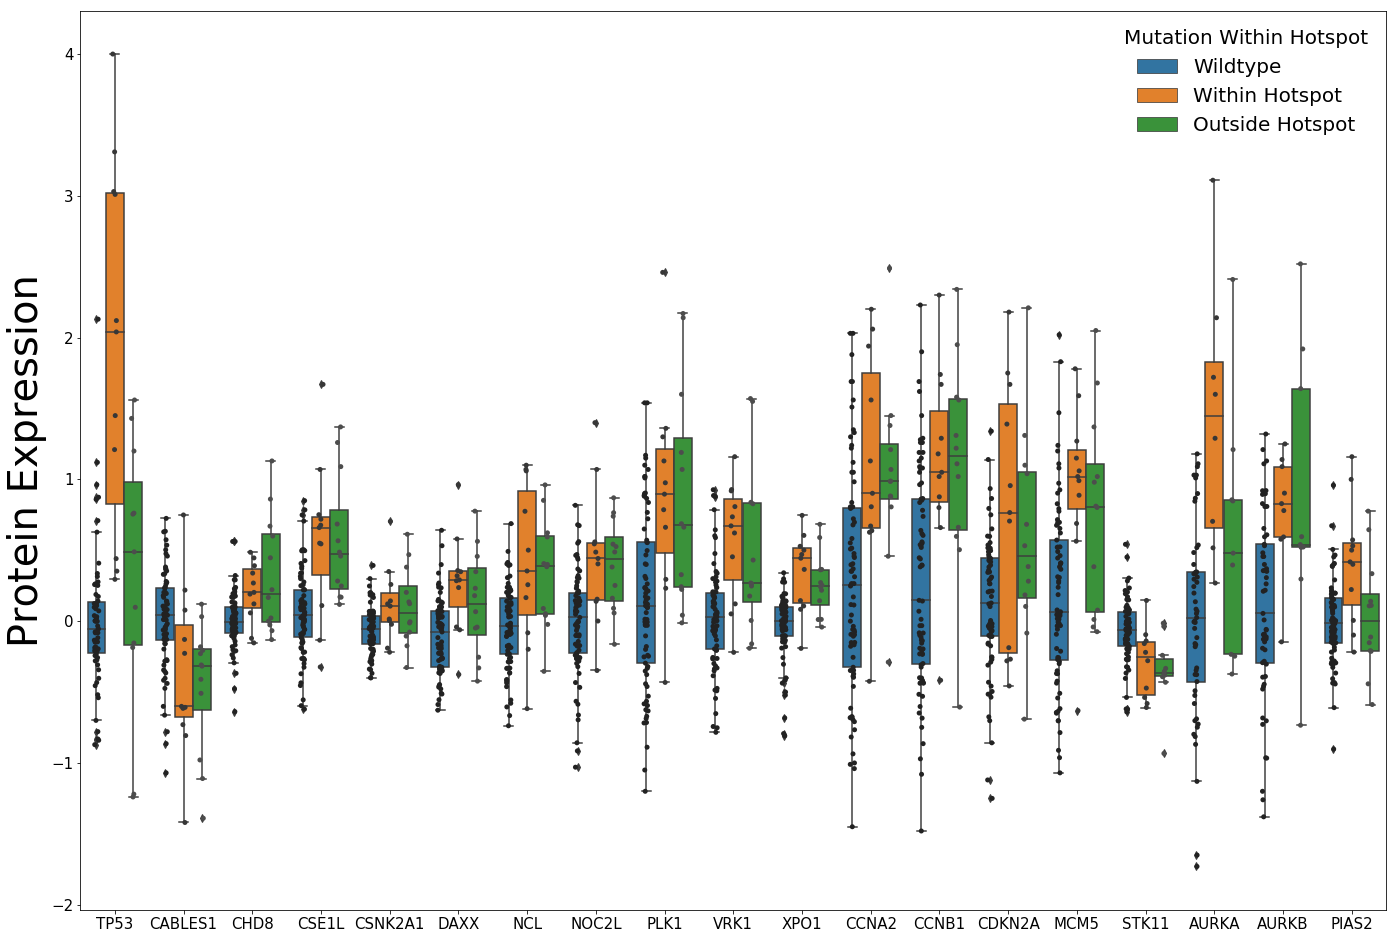

In [37]:
proteins_to_plot = []
for k, v in significant_all_mut_wt.items():
    proteins_to_plot.append(k)

# Add the one where mutation location makes a difference
proteins_to_plot.append('PIAS2')

plotdf = CPTAC.compare_mutations(proteomics, gene)
plotdf = plotdf.loc[plotdf['Patient_Type'] == 'Tumor'][[gene, 'Mutation']]
for protein in proteins_to_plot:
    proteindf = CPTAC.compare_mutations(proteomics, protein, gene)[[protein]]
    plotdf = plotdf.join(proteindf)

plotdf['Within_Hotspot'] = 'Outside Hotspot'
plotdf.loc[hotspot_patients, 'Within_Hotspot'] = 'Within Hotspot'
plotdf.loc[plotdf['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'
plotdf = pd.melt(plotdf, id_vars = ['Mutation', 'Within_Hotspot'], var_name = 'Protein', value_name = 'Proteomics')
plotdf = plotdf.dropna(axis = 0)

a4_dims = (23.4, 16.54)
fig, ax = plt.subplots(figsize=a4_dims)

#Create the plot
boxplt = sns.boxplot(x='Protein', y='Proteomics', hue='Within_Hotspot', hue_order = ['Wildtype', 'Within Hotspot', 'Outside Hotspot'], data=plotdf)
boxplt = sns.stripplot(data=plotdf, x='Protein', y='Proteomics', hue='Within_Hotspot', hue_order = ['Wildtype', 'Within Hotspot', 'Outside Hotspot'], dodge=True, jitter=True, color='.3')

#Add styling
boxplt.set_xlabel('')
boxplt.set_ylabel('Protein Expression', fontsize='40')
boxplt.tick_params(labelsize='15')

#Adjust legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:3], ['Wildtype', 'Within Hotspot', 'Outside Hotspot'], title='Mutation Within Hotspot', fontsize='20', frameon=False)
boxplt.get_legend().get_title().set_fontsize('20')
boxplt.get_legend().set_bbox_to_anchor((1, 1, 0, 0))